In [1]:
n_threads = 6

In [2]:
import os
if n_threads is not None:
    os.environ["OMP_NUM_THREADS"] = str(n_threads)

In [3]:
import yaml
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gpytorch.means import ConstantMean

from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import UpperConfidenceBoundGenerator, ExpectedImprovementGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

from utils import plot_model_in_2d

## Define VOCS

In [4]:
filename = "../variables.csv"
VARIABLE_RANGES = pd.read_csv(filename, index_col=0, header=None).T.to_dict(orient='list')
VARIABLES = ["SOLN:IN20:121:BCTRL", "QUAD:IN20:121:BCTRL"]

vocs = VOCS(
    variables = {ele: VARIABLE_RANGES[ele] for ele in VARIABLES},
    objectives = {"total_size": "MINIMIZE"},
    constraints = {"c1": ["LESS_THAN", 0.0]},
)
print(vocs.as_yaml())

variables:
  SOLN:IN20:121:BCTRL: [0.377, 0.498]
  QUAD:IN20:121:BCTRL: [-0.021, 0.021]
constraints:
  c1: [LESS_THAN, 0.0]
objectives: {total_size: MINIMIZE}
constants: {}
observables: []



## Define NN prior

In [5]:
model_path = "lcls_cu_injector_nn_model/"

# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_path + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_path + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_path + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_path + "model/output_pv_to_sim.pt")

# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(open(model_path + "model/pv_variables.yml"))

# replace keys in input variables
input_variables = {name.replace("BACT", "BCTRL"): ele for name, ele in input_variables.items()}

# create LUME-model
lume_model = PyTorchModel(
    model_file=model_path + "model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[output_sim_to_nn, output_pv_to_sim],
)

# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=vocs.variable_names,
    output_order=lume_model.outputs[0:2],
)

# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2)

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)

In [6]:
class PriorMean(torch.nn.Module):
    def __init__(self, model):
        super(PriorMean, self).__init__()
        self.model = model

    def forward(self, x) -> torch.Tensor:
        return self.model(x) + 500.0

## Define evaluate function

In [7]:
def get_model_predictions(input_dict, generator = None):
    output_dict = {}
    for output_name in generator.vocs.output_names:
        if generator is not None and generator.data is not None and not generator.data.empty:
            gp = generator.model.models[generator.vocs.output_names.index(output_name)]
            x = torch.tensor([input_dict[k] for k in generator.vocs.variable_names], dtype=torch.double).unsqueeze(0)
            with torch.no_grad():
                _x = gp.input_transform.transform(x)
                _x = gp.mean_module(_x)
                prior_mean = gp.outcome_transform.untransform(_x)[0].item()
                posterior = gp.posterior(x)
                posterior_mean = posterior.mean.item()
                posterior_sd = torch.sqrt(posterior.mvn.variance).item()
        else:
            prior_mean, posterior_mean, posterior_sd = np.nan, np.nan, np.nan
    
        output_dict[output_name + "_prior_mean"] = prior_mean
        output_dict[output_name + "_posterior_mean"] = posterior_mean
        output_dict[output_name + "_posterior_sd"] = posterior_sd
    return output_dict

In [8]:
# Xopt evaluator function
def evaluate(input_dict, generator = None):
    model_result = lume_model.evaluate(input_dict)
    sigma_xy = objective_model.function(model_result["OTRS:IN20:571:XRMS"], model_result["OTRS:IN20:571:YRMS"])
    output_dict = {vocs.objective_names[0]: sigma_xy.detach().item()}
    
    # dummy constraint
    output_dict["c1"] = output_dict[vocs.objective_names[0]] - 3e3

    # GP model predictions
    model_predictions = get_model_predictions(input_dict, generator)
    output_dict.update(model_predictions)
    
    return output_dict

## Restrict ranges based on profile monitor

In [9]:
vocs.variables = {k: input_variables[k].value_range for k in vocs.variable_names}
vocs.variables["SOLN:IN20:121:BCTRL"] = [0.467, 0.479]
print(vocs.as_yaml())

variables:
  QUAD:IN20:121:BCTRL: [-0.02098429469554406, 0.020999198106589838]
  SOLN:IN20:121:BCTRL: [0.467, 0.479]
constraints:
  c1: [LESS_THAN, 0.0]
objectives: {total_size: MINIMIZE}
constants: {}
observables: []



## Run Xopt

In [10]:
from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import UpperConfidenceBoundGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor

# remember to set use low noise prior to false!!!
model_constructor = StandardModelConstructor(
    use_low_noise_prior=False,
    mean_modules={"total_size": PriorMean(objective_model)},
)
generator = ExpectedImprovementGenerator(
    vocs=vocs,
    model_constructor=model_constructor,
)
generator.numerical_optimizer.max_iter = 200
evaluator = Evaluator(function=evaluate, function_kwargs={"generator": None})
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.evaluator = Evaluator(function=evaluate, function_kwargs={"generator": X.generator})

In [11]:
X.random_evaluate(3, seed=0)

,QUAD:IN20:121:BCTRL,SOLN:IN20:121:BCTRL,total_size,c1,total_size_prior_mean,total_size_posterior_mean,total_size_posterior_sd,c1_prior_mean,c1_posterior_mean,c1_posterior_sd,xopt_runtime,xopt_error
0,-0.005743,0.478802,357.371522,-2642.628478,NaN,NaN,NaN,NaN,NaN,NaN,0.001471,False
1,0.009673,0.469241,612.418222,-2387.581778,NaN,NaN,NaN,NaN,NaN,NaN,0.000517,False
2,0.019279,0.468047,736.608305,-2263.391695,NaN,NaN,NaN,NaN,NaN,NaN,0.000348,False


In [12]:
%%time
for i in range(50):
    X.step()

CPU times: user 4min 47s, sys: 1min 1s, total: 5min 48s
Wall time: 3min 15s


## Display GP Models

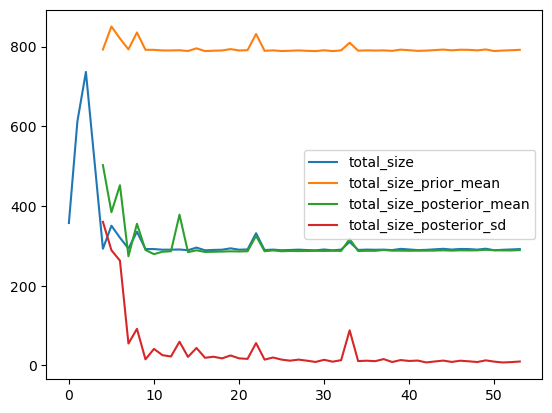

In [13]:
X.data[["total_size" + k for k in ["", "_prior_mean", "_posterior_mean", "_posterior_sd"]]].plot();

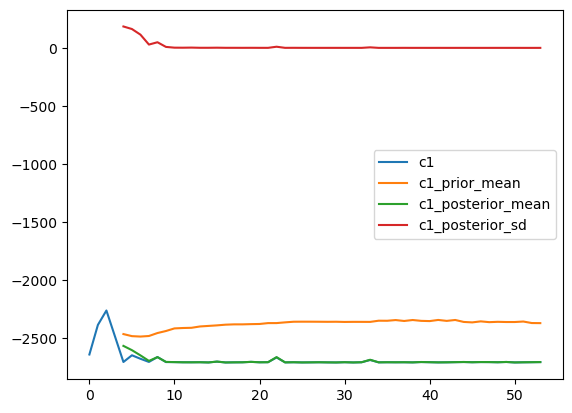

In [14]:
X.data[["c1" + k for k in ["", "_prior_mean", "_posterior_mean", "_posterior_sd"]]].plot();

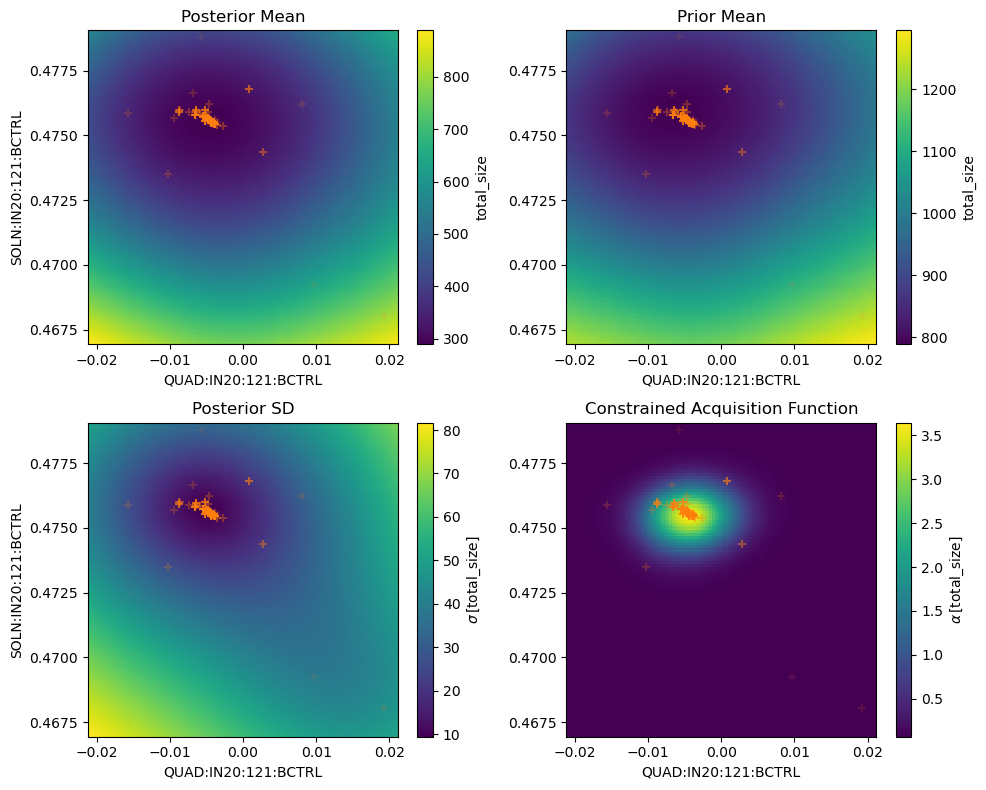

In [15]:
fig, ax = plot_model_in_2d(
    X=X,
    output_name="total_size",  # should also work for constraints
    variable_names=None,  # provides option to view 2D slices at higher dimensions
    constrained_acqf=True,  # display the constrained or basic acquisition function
    n_grid=100,  # number of grid points per dimension
    figsize=(10,8),
    show_samples=True,
    fading_samples=True,  # older samples are more transparent
)

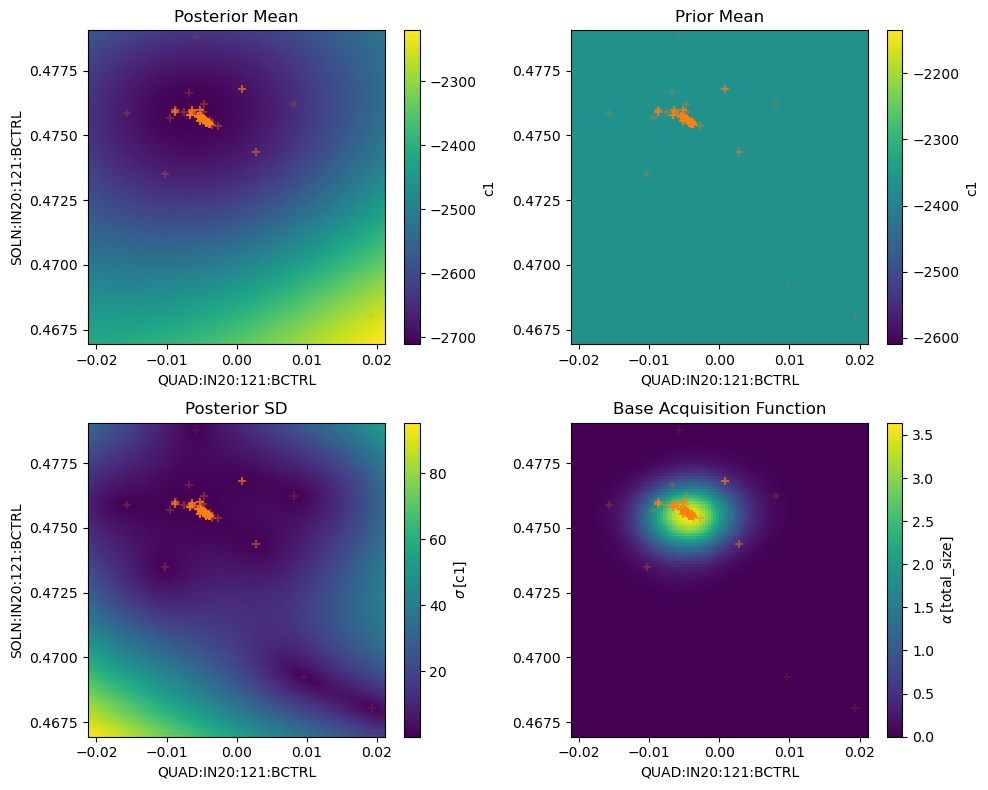

In [16]:
fig, ax = plot_model_in_2d(
    X=X,
    output_name="c1",  # should also work for constraints
    variable_names=None,  # provides option to view 2D slices at higher dimensions
    constrained_acqf=False,  # display the constrained or basic acquisition function
    n_grid=100,  # number of grid points per dimension
    figsize=(10,8),
    show_samples=True,
    fading_samples=True,  # older samples are more transparent
)